This notebook demonstrates how to reconstruct an ogr gmt file with **pygplates**.

The rotation model used in this notebook is from https://www.earthbyte.org/muller-et-al-2019-deforming-plate-reconstruction-and-seafloor-age-grids-tectonics/.

This notebook also demonstrates how to plot the reconstructed polygons with **Cartopy** and how to deal with the infamous **dateline problem**.

In [1]:
from pathlib import Path

import pygplates

start_time=0
end_time=11
time_step=1

gmt_data = pygplates.FeatureCollection('Data/Contourites_Thran_etal_EPSL2018.gmt')

# static polygons are the 'partitioning features'
static_polygons = pygplates.FeatureCollection(
    'Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp')

# The partition_into_plates function requires a rotation model, since sometimes this would be
# necessary even at present day (for example to resolve topological polygons)
rotation_model=pygplates.RotationModel(
    ['Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/Global_250-0Ma_Rotations_2019_v2.rot',
    'Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/Global_410-250Ma_Rotations_2019_v2.rot'])

coastlines = pygplates.FeatureCollection(
    'Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp')

# partition features
partitioned_gmt_data = pygplates.partition_into_plates(
    static_polygons,
    rotation_model,
    gmt_data,
    partition_method = pygplates.PartitionMethod.most_overlapping_plate,
    properties_to_copy = [
            pygplates.PartitionProperty.reconstruction_plate_id,
            pygplates.PartitionProperty.valid_time_period]
)

try:
    out_folder='./gmt_output'
    Path(out_folder).mkdir(parents=True, exist_ok=True)
    #save the contourites data with plate id and valid time period
    pygplates.FeatureCollection(partitioned_gmt_data).write(f'{out_folder}/contourites.gpmlz')

    for time in range(start_time,end_time,time_step):
        #reconstruct the contourites to time
        pygplates.reconstruct(partitioned_gmt_data,
                      rotation_model,
                      f'{out_folder}/contourites_{time}_Ma.gmt',
                      float(time)) 
        print(f'{time}, ',end='')

except IOError:
    print('Unable to save output files.')
print('All done!')



0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, All done!


In [2]:
time=10.
reconstructed_feature_geometries = []
pygplates.reconstruct(partitioned_gmt_data,
                      rotation_model,
                      reconstructed_feature_geometries,
                      time) 

reconstructed_coastlines = []
pygplates.reconstruct(coastlines,
                      rotation_model,
                      reconstructed_coastlines,
                      time) 

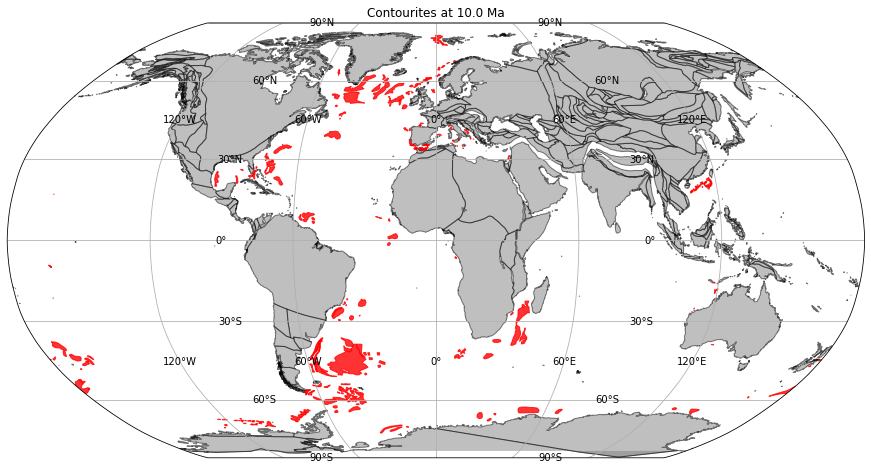

In [3]:
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from shapely.geometry.polygon import LinearRing
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.Robinson())

coastlines=[]
date_line_wrapper = pygplates.DateLineWrapper(0.0)
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        coastlines.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
              

polygons=[]
for rfg in reconstructed_feature_geometries:
    wrapped_polygons = date_line_wrapper.wrap(rfg.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        polygons.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))

ax.add_geometries(coastlines, ccrs.PlateCarree(), facecolor='gray', edgecolor='black', alpha=0.5) 
ax.add_geometries(polygons, crs=ccrs.PlateCarree(), facecolor='red', edgecolor='red', alpha=0.8)

ax.gridlines(draw_labels=True, dms=True, x_inline=True, y_inline=True)

plt.title(f'Contourites at {time} Ma')
plt.show()